## One step approach


In [2]:
# Import
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import pandas as pd

import mlflow
import logging 
import config 

from basic_functions import (
    get_preprocess_data,
    get_lemmatized_data,
    get_metrics
)


### Setup

In [3]:
MODEL_NAME = "logistic_regression" 
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [4]:
DATA_PATH = "../data/data_tiny.csv"

In [5]:
#setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "LogReg 1step")
mlflow.log_param("dataset", DATA_PATH)

Active run_id: 35ff6f37102541e68710b11503391e32


'../data/data_tiny.csv'

### Model Initialization

In [6]:
df = get_preprocess_data(DATA_PATH)
df = get_lemmatized_data(df)

X = df['text']
y = df['logical_fallacies']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Bigrams (or even trigrams)
    max_features=1000,   # Limit feature space to the most important words
    min_df=5,            # Consider words that appear in at least 5 documents
    max_df=0.9)       # Ignore words that appear in more than 90% of documents)
    
X_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_vectorized_test = tfidf_vectorizer.transform(X_test)

one_model = LogisticRegression(
    penalty='l2',  # most of the solvers only work with l2
    random_state=42,
    class_weight='balanced', 
    verbose=0, 
    n_jobs=-1, 
    )

param_grid_one = {
    # 'penalty' :['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [100, 500, 1000],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear']
}

cv = StratifiedKFold(5)

grid_search_one = GridSearchCV(one_model, param_grid_one, cv=cv)
grid_search_one.fit(X_vectorized, y_train)

best_params_one = grid_search_one.best_params_
print(best_params_one)

# log params for binary model
for k,v in best_params_one.items():
    mlflow.log_param(f"best_param_{k}", v)

best_model_one = grid_search_one.best_estimator_
y_train_pred_one = best_model_one.predict(X_vectorized)
y_test_pred_one = best_model_one.predict(X_vectorized_test)

/Users/aylinhanne/Documents/neuefische/capstone_project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/aylinhanne/Documents/neuefische/capstone_project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/aylinhanne/Documents/neuefische/capstone_project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/aylinhanne/Documents/neuefische/capstone_project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWar

{'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}


### Evaluation

In [7]:
def log_metrics(cr, split):
    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

INFO:root:get train metrics for one-step approach
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                       precision    recall  f1-score   support

           ad_hominem       0.93      0.78      0.85        18
  appeal_to_authority       0.73      0.89      0.80         9
    appeal_to_emotion       0.83      1.00      0.91        10
        false_dilemma       1.00      0.64      0.78        11
faulty_generalization       1.00      1.00      1.00        13
                 none       0.75      1.00      0.86         9

             accuracy                           0.87        70
            macro avg       0.87      0.88      0.87        70
         weighted avg       0.89      0.87      0.87        70

[[14  1  2  0  0  1]
 [ 0  8  0  0  0  1]
 [ 0  0 10  0  0  0]
 [ 1  2  0  7  0  1]
 [ 0  0  0  0 13  0]
 [ 0  0  0  0  0  9]]


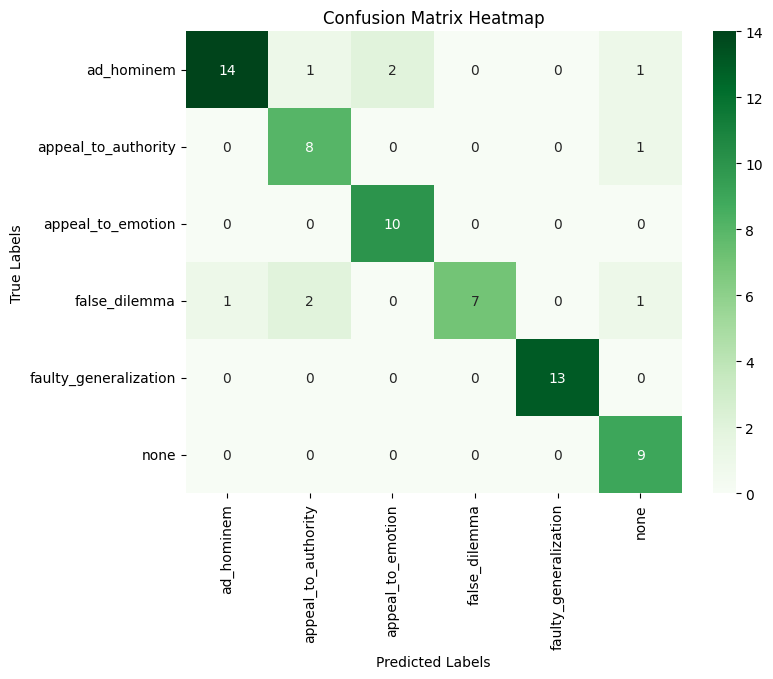

In [8]:
logger.info('get train metrics for one-step approach')
classification_report_one_train = get_metrics(y_train, y_train_pred_one)
log_metrics(classification_report_one_train, 'train')

INFO:root:get test metrics for one-step approach
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                       precision    recall  f1-score   support

           ad_hominem       0.22      0.25      0.24         8
  appeal_to_authority       0.50      0.50      0.50         4
    appeal_to_emotion       0.00      0.00      0.00         5
        false_dilemma       0.00      0.00      0.00         4
faulty_generalization       0.00      0.00      0.00         5
                 none       0.00      0.00      0.00         4

             accuracy                           0.13        30
            macro avg       0.12      0.12      0.12        30
         weighted avg       0.13      0.13      0.13        30

[[2 0 3 1 1 1]
 [0 2 0 0 0 2]
 [3 0 0 0 1 1]
 [0 1 1 0 1 1]
 [2 0 0 2 0 1]
 [2 1 0 0 1 0]]


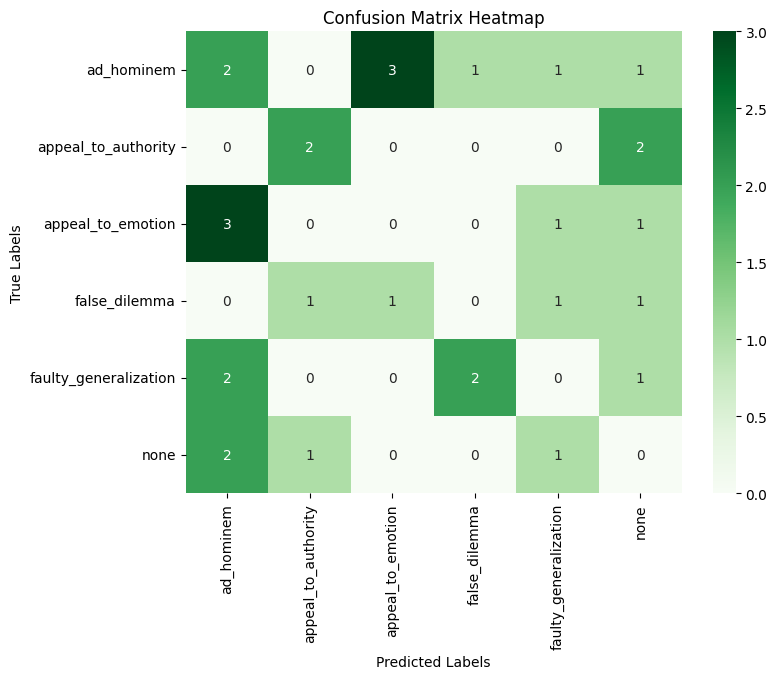

In [9]:
logger.info('get test metrics for one-step approach')
classification_report_one_test = get_metrics(y_test, y_test_pred_one)
log_metrics(classification_report_one_test, 'test')

In [10]:
mlflow.end_run()

🏃 View run LogReg 1step at: http://127.0.0.1:5001/#/experiments/861649519414732270/runs/35ff6f37102541e68710b11503391e32
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/861649519414732270
